In [16]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
# from math import floor
# import pandas as pd 
# import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras

from tensorflow_examples.models.pix2pix import pix2pix
import time
from IPython.display import clear_output

# import tensorflow.keras.layers as layers

# from tensorflow.keras.initializers import RandomNormal
# from tensorflow.keras.optimizers import Adam
from numpy.random import randn

# import tensorflow_addons as tfa

In [17]:
TFREC_DIR = "tfrec"
BATCH_SIZE=1

In [18]:

monet_filenames=tf.io.gfile.glob(str(TFREC_DIR+'/monet_tfrec/*.tfrec'))
photo_filenames=tf.io.gfile.glob(str(TFREC_DIR + '/photo_tfrec/*.tfrec'))

print('monet_filenames',len(monet_filenames))
print('photo_filenames',len(photo_filenames))


AUTOTUNE = tf.data.experimental.AUTOTUNE 
print(tf.__version__)



image_size=[256,256]
def decode_img(img):
    img=tf.image.decode_image(img,channels=3)
    img=(tf.cast(img,tf.float32)/127.5)-1
    img=tf.reshape(img,[*image_size,3])
    return img



def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_img(example['image'])
    return image

def load_dataset(filenames,labeled=True,ordered=False):
    dataset=tf.data.TFRecordDataset(filenames)
    dataset=dataset.map(read_tfrecord,num_parallel_calls=AUTOTUNE)
    return dataset


monet_ds=load_dataset(monet_filenames,labeled=True).batch(BATCH_SIZE)
photo_ds=load_dataset(photo_filenames,labeled=True).batch(BATCH_SIZE)

monet_filenames 5
photo_filenames 20
2.7.0


In [19]:
train_monet = monet_ds.take(240) 
test_monet = monet_ds.skip(60)

train_photo = photo_ds.take(5631) 
test_photo = photo_ds.skip(1407)


In [20]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [21]:
sample_photo = next(iter(train_photo))
sample_monet = next(iter(train_monet))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


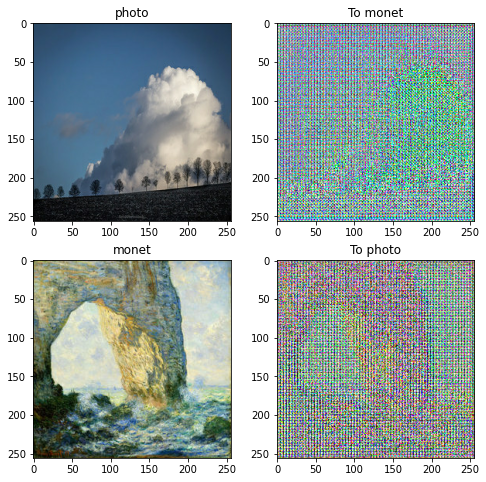

In [22]:
to_monet = generator_g(sample_photo)
to_photo = generator_f(sample_monet)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_photo, to_monet, sample_monet, to_photo]
title = ['photo', 'To monet', 'monet', 'To photo']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

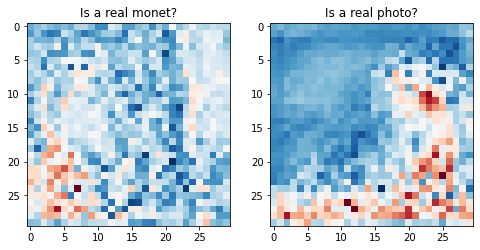

In [24]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real monet?')
plt.imshow(discriminator_y(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real photo?')
plt.imshow(discriminator_x(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [25]:
LAMBDA = 10

In [26]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [28]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [29]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [30]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [31]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [32]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [33]:
EPOCHS = 40

In [34]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [35]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [36]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_photo, train_monet)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_photo) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_photo)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

.

KeyboardInterrupt: 